In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from url_parser import parse_url
import numpy as np

client = Client()

distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-612rb9cd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-wwtsfnf3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-f6sxngfq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-jp4g30oe', purging
distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-ii21kygb', purging
distributed.diskutils - INFO - Found stale lock file and directory '/fastdrive/stele/dask-worker-space/worker-vbn8yiwh', purging


In [2]:
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33137,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:42603,Total threads: 4
Dashboard: http://127.0.0.1:39059/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:38631,


In [51]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()

In [52]:
dat = dd.read_parquet("data/output")

In [53]:
#only_us = dat[(dat.Actor1Code == "USA") & (dat.Actor2Code == "CHN")]
#only_china = dat[(dat.Actor1Code == "CHN") & (dat.Actor2Code == "USA")]
dat.head()

/home/parvus/anaconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():


,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [86]:
from sklearn.preprocessing import StandardScaler

counts = dat.groupby("SQLDATE").size().compute()
counts = counts.sort_index()
counts_arr = counts.values[1300:]

split_size = 30
stride_length = 1
num_splits = (len(counts_arr) - split_size) // stride_length + 1
counts_arr_strided = np.lib.stride_tricks.as_strided(
                counts_arr, 
                shape=(num_splits, split_size), 
                strides=(stride_length*counts_arr.strides[0], counts_arr.strides[0]))

scaler = StandardScaler()
counts_arr_strided = scaler.fit_transform(counts_arr_strided)

counts_arr_strided.shape

(985, 30)

In [87]:
x = np.array([item[:29] for item in counts_arr_strided])
y = np.array([item[-1]  for item in counts_arr_strided])

print(x.shape)
print(y.shape)

(985, 29)
(985,)


In [88]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [89]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)

In [90]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.06493302896463288


In [91]:
ridge = Ridge()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.06469754040364743


In [92]:
lasso = Lasso()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.8958009678157226


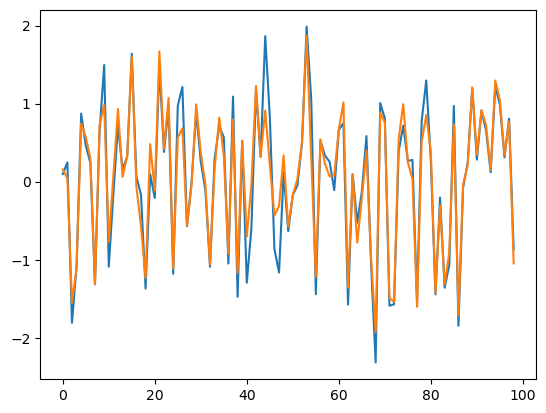

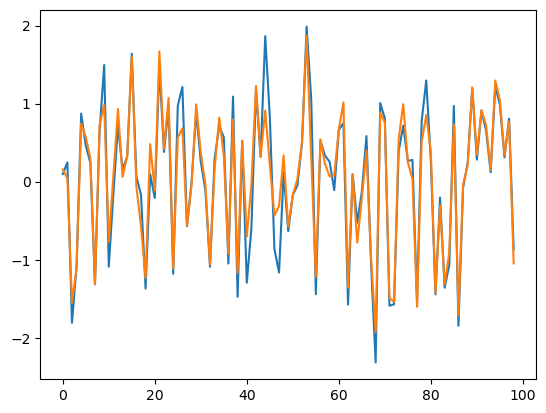

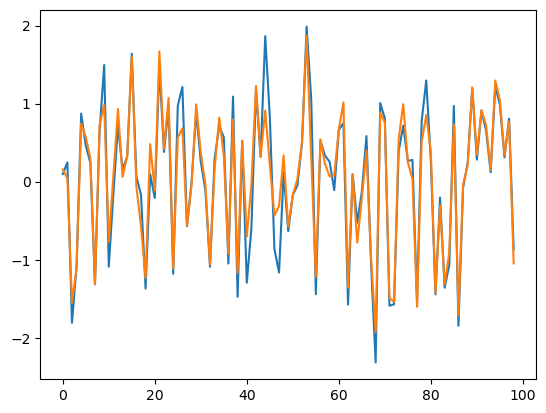

In [93]:
import matplotlib.pyplot as plt

def viz_test_out(model, x_test, y_test):
    preds = []
    y_reals = []

    for inp, y_real in zip(x_test, y_test):
        y_pred = linear_model.predict([inp])
        preds.append(y_pred)
        y_reals.append(y_real)


    plt.plot(y_reals)
    plt.plot(preds)
    plt.show()

viz_test_out(linear_model, x_test, y_test)
viz_test_out(ridge, x_test, y_test)
viz_test_out(lasso, x_test, y_test)

0 -0.0005098408879421201
1 0.0014462610636500617
2 -0.0025236800246295696
3 0.0011784303016634384
4 0.001422008215110418
5 -0.002620824203234118
6 0.004322489877026284
7 -0.002620587714015271
8 -0.0015281783983270014
9 0.0021713900092049133
10 -0.002586141337493908
11 0.0029161665504241208
12 -0.0014507800916915906
13 0.002145477109889833
14 -0.0031084780190036854
15 0.00043356555193951873
16 -0.000830375327261268
17 0.003023998848207362
18 -0.002380400310760422
19 -0.0003384355718979923
20 0.004123451649629566
21 -0.0061109768647110985
22 0.00304264473795135
23 -0.0013426519194762176
24 -0.00025596641678737875
25 -0.0020375508227971142
26 0.0038202043523939133
27 -0.008848161760164452
28 0.009608266429578238


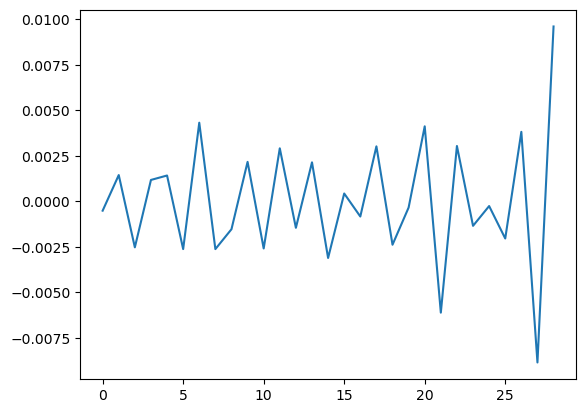

In [94]:
diffs = []
for idx, diff in enumerate((linear_model.coef_ - ridge.coef_)):
    print(idx, diff)
    diffs.append(diff)

plt.plot(diffs)
plt.show()

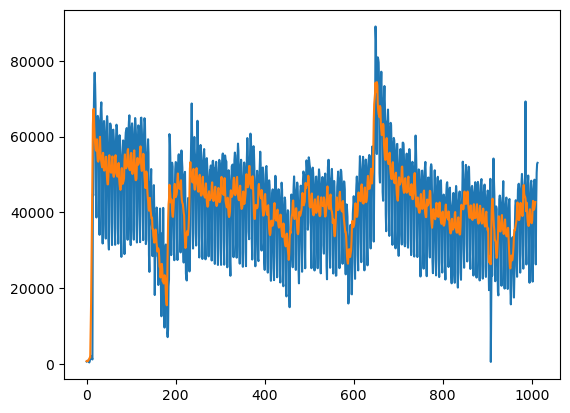

In [95]:
# https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w
counts_arr_ma = moving_average(counts_arr,6)

plt.plot(counts_arr)
plt.plot(counts_arr_ma)
plt.show()

In [96]:
counts_arr_strided = np.lib.stride_tricks.as_strided(
                counts_arr_ma, 
                shape=(num_splits, split_size), 
                strides=(stride_length*counts_arr_ma.strides[0], counts_arr_ma.strides[0]))

scaler = StandardScaler()
counts_arr_strided = scaler.fit_transform(counts_arr_strided)

counts_arr_strided.shape

(985, 30)

In [97]:
x = np.array([item[:29] for item in counts_arr_strided])
y = np.array([item[-1]  for item in counts_arr_strided])

print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)

(985, 29)
(985,)


In [98]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.019023105787401934


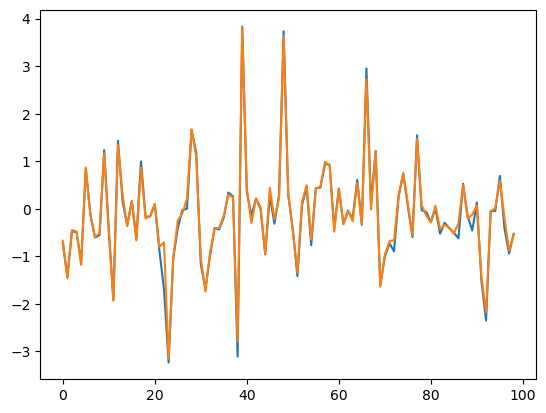

In [99]:
viz_test_out(linear_model, x_test, y_test)